# Algoritmo

In [1]:
from itertools import combinations
import igraph as ig
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import K2Score, MaximumLikelihoodEstimator
import random
import pandas as pd
import copy

In [8]:
from itertools import combinations
import igraph as ig
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import K2Score, MaximumLikelihoodEstimator
import random
import pandas as pd
import copy


def combinaciones_var(variables_names):
    # Generar todas las combinaciones posibles de aristas
    all_possible_edges = [(u, v) for u in variables_names for v in variables_names if u != v]
    return all_possible_edges

# Función para verificar si una estructura es un DAG 
def is_dag(edges, nodes):
    G = ig.Graph(directed=True)
    G.add_vertices(nodes)
    G.add_edges(edges)
    cycles = G.feedback_arc_set()
    return not cycles

def invertir_direccion(edges, variables):
    if len(edges) == 1:
        return [(edges[0][1], edges[0][0])]

    possible_edges = edges[:] # lista auxiliar
    random.shuffle(possible_edges) # barajar las variables
    
    for al in possible_edges:
        reverso = (al[1], al[0])
        index = edges.index(al)
        edges[index] = reverso
        
        if is_dag(edges, variables):
            return edges
        else:
            edges[index] = al

    return edges

def add_arco(edges, tupla, nodes):
    # Convertir la lista de tuplas en una tupla única concatenada
    tup = tuple([item for sublist in tupla for item in sublist])

    # Obtener todos los arcos posibles a agregar
    possible_arcs = [t for t in edges if t not in tupla and t[0] in tup]

    # Barajar los arcos posibles para intentar en orden aleatorio
    random.shuffle(possible_arcs)

    for r in possible_arcs:
        tupla.append(r)
        if is_dag(tupla, nodes):
            return tupla
        else:
            tupla.remove(r)

    # Si no se puede agregar ningún arco sin formar un ciclo, retornar la estructura original
    return tupla

def delete_arco(estructura):
    if len(estructura) > 1:
        eliminar = random.choice(estructura)
        estructura.remove(eliminar)
        return estructura
    else:
        return estructura


# Cargar el conjunto de datos
df = pd.read_csv('C:/Users/abrah/Downloads/lentes.csv')
# Obtener los nombres de las variables
all_var = list(df.columns)

# Generar las combinaciones entre pares de variables
combinaciones = combinaciones_var(all_var)

all_estructuras = [] # Almacenar las estructuras evaluadas
all_scores = []

# Mejores puntajes y estructuras
best_puntaje_k2 = float('inf')
best_structure_k2 = None
# Empezar con una estructura inicial al azar
estructura_ = [random.choice(combinaciones)]
#estructura_ = [('Astigmatismo', 'Lagrima')]
scoresss = []

iterations_con_mejora = 0
max_iterations_con_mejora = 5 # maximo de iteraciones en caso de que el puntaje no mejore

for i in range(100):
    if iterations_con_mejora >= max_iterations_con_mejora:
        break

    seleccion = random.randint(1, 3)
    
    if seleccion == 1 and len(estructura_) < len(all_var) * (len(all_var) - 1):
        estructura_ = add_arco(combinaciones, estructura_, all_var)
    elif seleccion == 2:
        estructura_ = invertir_direccion(estructura_, all_var)
    else:
        estructura_ = delete_arco(estructura_)

    all_estructuras.append(estructura_)

    model = BayesianNetwork(estructura_)
    model.fit(df, estimator=MaximumLikelihoodEstimator)
    k2 = K2Score(df)
    score = k2.score(model)
    scoresss.append(score)

    mejora = False
    # Guardar los mejores puntajes y estructuras
    if score < best_puntaje_k2:
        best_puntaje_k2 = score
        best_structure_k2 = copy.deepcopy(estructura_)  # Usar deepcopy para evitar referencias
        all_scores.append(best_puntaje_k2)
        mejora = True
    # Verificar si hubo alguna mejora
    if mejora:
        iterations_con_mejora = 0 # si el puntaje sigue mejorando, el contador se actualiza a 0
    else:
        iterations_con_mejora += 1 # si no hay cambios en el resultado de la metrica, se le aumenta 1

print("Mejor estructura K2:", best_structure_k2)
print("Mejor puntaje K2:", best_puntaje_k2)
print(f'Total de estructuras evaluadas: {len(all_estructuras)}')


Mejor estructura K2: [('Edad', 'Lagrima'), ('Astigmatismo', 'Lagrima'), ('Edad', 'Recomendacion'), ('Edad', 'Diagnostico')]
Mejor puntaje K2: -113.1378237027195
Total de estructuras evaluadas: 16


1.-Resultados:
    Mejor estructura K2: [('Edad', 'Lagrima'), ('Astigmatismo', 'Lagrima'), ('Edad', 'Recomendacion'), ('Edad', 'Diagnostico')]
    Mejor puntaje K2: -113.1378237027195
    Total de estructuras evaluadas: 16

Entrenar y clasificar

In [2]:
# cargar el conjunto de datos
df = pd.read_csv('C:/Users/abrah/Downloads/lentes.csv')

In [3]:
best_structure_k2 = [('Edad', 'Lagrima'), ('Astigmatismo', 'Lagrima'), ('Edad', 'Recomendacion'), ('Edad', 'Diagnostico')]
best_model = BayesianNetwork(best_structure_k2)
best_model.fit(df, estimator=MaximumLikelihoodEstimator)

In [4]:
from pgmpy.inference import VariableElimination
# permite hacer preguntas a nuestro modelo bayesiano entrenado.
infer = VariableElimination(best_model) # actualizacion de creencias

In [5]:
# Ejemplo de predicción con nuevas observaciones
nueva_observacion = {'Edad': 'Prepresbicia','Astigmatismo': 'No', 'Lagrima': 'Normal'}
# infer.map_query: realiza inferencia sobre la red bayesiana.
# Inferencia MAP (Maximum A Posteriori).
# Utiliza el algoritmo de inferencia (eliminación de variables) para calcular la probabilidad de cada posible valor de la variable 'Recomendacion' dado los valores observados
# Devuelve el valor de 'Recomendacion' que maximiza la probabilidad condicional dada la evidencia proporcionada.
# Eliminación de Variables:  elimina las variables no deseadas en una red bayesiana para calcular la probabilidad marginal de las variables de interés.
prediccion = infer.map_query(variables=['Recomendacion'], evidence=nueva_observacion)
print("Predicción para la nueva observación:", prediccion)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Predicción para la nueva observación: {'Recomendacion': 'Ninguna'}


In [13]:
prediccion_proba = infer.query(variables=['Recomendacion'], evidence=nueva_observacion)
print("Prediccion para 'Recomendacion':", prediccion_proba)

Prediccion para 'Recomendacion': +------------------------+----------------------+
| Recomendacion          |   phi(Recomendacion) |
+========================+======================+
| Recomendacion(Blandas) |               0.2500 |
+------------------------+----------------------+
| Recomendacion(Duras)   |               0.1250 |
+------------------------+----------------------+
| Recomendacion(Ninguna) |               0.6250 |
+------------------------+----------------------+


In [7]:
# Para obtener la probabilidad de tener 'astigmatismo' dado que tiene 'joven'
probabilidad_astigmatismo = infer.query(variables=['Astigmatismo'], evidence={'Edad': 'Joven'})
print("Probabilidad de tener astigmatismo dado que tiene prepresbicia:", probabilidad_astigmatismo)

Probabilidad de tener astigmatismo dado que tiene prepresbicia: +------------------+---------------------+
| Astigmatismo     |   phi(Astigmatismo) |
+==================+=====================+
| Astigmatismo(No) |              0.5000 |
+------------------+---------------------+
| Astigmatismo(Si) |              0.5000 |
+------------------+---------------------+


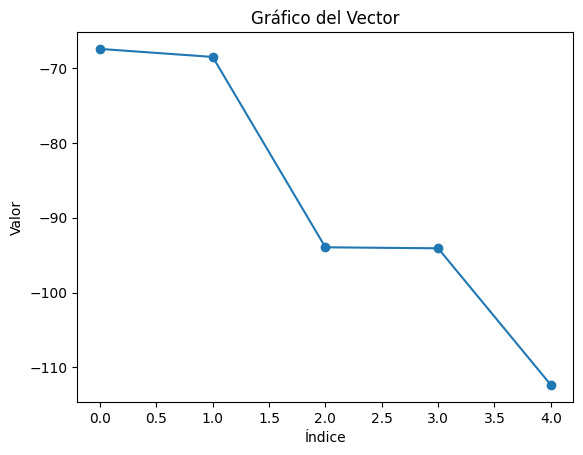

In [6]:
import matplotlib.pyplot as plt

# Crear el gráfico
plt.plot(all_scores, marker='o')

# Agregar título y etiquetas
plt.title('Gráfico del Vector')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

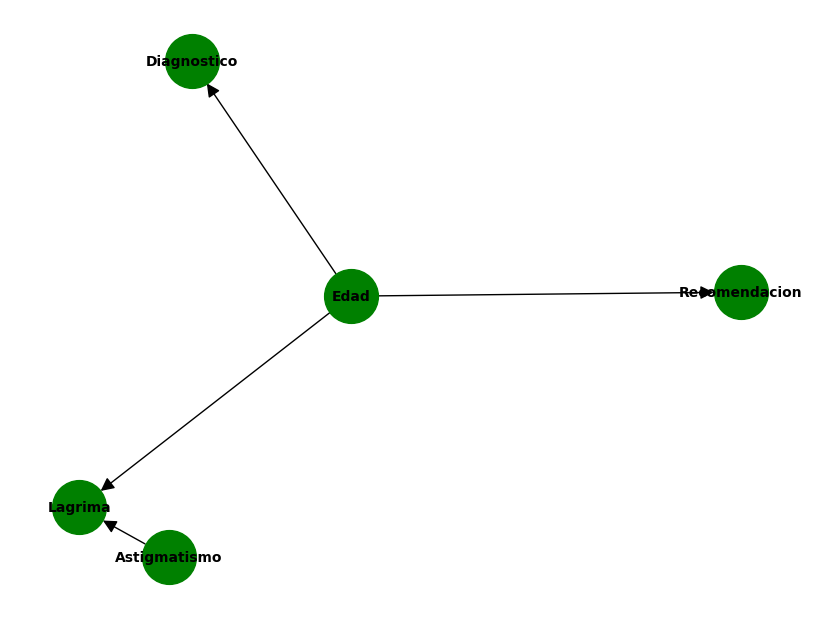

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# obtener el modelo grafico de la red bayesiana
data = best_structure_k2

df = pd.DataFrame(data, columns=['Source', 'Target'])

# Crear un grafo dirigido
G = nx.from_pandas_edgelist(df, source='Source', target='Target', create_using=nx.DiGraph())

colores = ['red', 'green', 'yellow', 'brown', 'purple', 'pink']
selec = random.choice(colores)

# Dibujar el grafo
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color=selec, font_size=10, font_weight="bold", arrowsize=20)
plt.show()